# Embed and Predict (BoW)

We treat each document as a Bag of Words (BoW), and just average the GloVe word embeddings to create document vectors, and run them through a 2 layer classifier network.

In [5]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import numpy as np
import logging
import os
%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")
WORD_EMBED_SIZE = 300

NUM_CLASSES = 20
BATCH_SIZE = 64
NUM_EPOCHS = 1000

logging.basicConfig()

## Load Vocabulary

In [7]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.decode('utf-8').strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
print(word2id)
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

{'marinara.mit.edu': 40069, '3:16': 22761, 'plc': 16996, 'eng.clemson.edu': 32612, 'censors': 11353, 'allegory': 38120, 'untested': 34328, 'sunshine': 27123, 'urbana-champaign': 10028, 'ets': 38880, 'erics': 11195, 'passe': 26696, 'waco': 1063, 'gim': 22777, 'cfs': 18953, 'cruz': 8215, 'commonly': 4004, 'm=te': 38674, 'grove': 14049, 'ohip': 35608, 'baalke': 3259, 'sister': 5641, '716': 10742, 'p\\v': 29633, '1929': 35721, 'forever': 2818, 'steel': 3854, 'roell': 24942, 'speakers': 4529, 'pooh.bears': 8815, 'unleaded': 35957, 's0t-': 18596, 'ethanb': 34612, 'forbidding': 16613, 's\\': 17950, 'print': 1458, 'unequivocal': 34694, 'chinese': 3698, 'loren': 21844, 'constitutionally': 25538, 'whales': 23994, 'n5qxr': 39075, 'detweiler': 15299, 'mini': 9976, 'country': 615, '70262,3610': 25964, 'c5so84.hxv': 36503, 'p2.y': 38315, 'sipps': 22169, 'skilled': 14050, 'v9f9f': 28882, 'vaseline': 17771, 'athena': 5947, 'smyrna': 34054, 'uncluttered': 26481, 'mutlu': 13113, 'bmp': 5099, 'chooses': 

## Load GloVe embeddings

In [8]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.decode('utf-8').strip().split(" ")
    word = cols[0]
    if not word in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E)
print(E.shape)

[[ 0.10179   0.5278    0.12629  ... -0.27129   0.33692  -0.89222 ]
 [ 0.82303  -0.4862    0.1664   ...  0.12718   0.44752  -0.076716]
 [ 0.27204  -0.06203  -0.1884   ...  0.13015  -0.18317   0.1323  ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]
(40683, 300)


## Compute Document Vectors

In [43]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [44]:
D = np.zeros((num_docs, WORD_EMBED_SIZE))
for i, text in enumerate(ng_data.data):
    doc_vec = np.zeros(WORD_EMBED_SIZE)
    num_words = 0
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            try:
                doc_vec += E[word2id[word]]
            except KeyError:
                doc_vec += E[word2id["UNK"]]
            num_words += 1
    doc_vec /= num_words
    D[i] = doc_vec
print(D.shape)

(18846, 300)


## Data Generation

In [45]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [46]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(D, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 300) (13192, 20) (5654, 300) (5654, 20)


## Define Network

In [47]:
inputs = Input(shape=(WORD_EMBED_SIZE, ))
fc1 = Dense(100, activation="relu")(inputs)
fc1_dropout = Dropout(0.2)(fc1)
fc2 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc2)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc1_dropout)

In [48]:
model = Model(inputs=inputs, outputs=outputs)

In [49]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
             metrics=["accuracy"])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
Total params: 32,120
Trainable params: 32,120
Non-trainable params: 0
_________________________________________________________________


## Train Network

In [58]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.5779 - acc: 0.1615 - val_loss: 2.5295 - val_acc: 0.1939
Epoch 2/1000
11872/11872 [==============================] - 0s 37us/step - loss: 2.5782 - acc: 0.1546 - val_loss: 2.5065 - val_acc: 0.1803
Epoch 3/1000
11872/11872 [==============================] - 0s 38us/step - loss: 2.5876 - acc: 0.1556 - val_loss: 2.4911 - val_acc: 0.1932
Epoch 4/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.5854 - acc: 0.1536 - val_loss: 2.5040 - val_acc: 0.2068
Epoch 5/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.5770 - acc: 0.1569 - val_loss: 2.4887 - val_acc: 0.1841
Epoch 6/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.5728 - acc: 0.1555 - val_loss: 2.5211 - val_acc: 0.1894
Epoch 7/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.5819 - acc: 0.1564 - val_loss: 2.4

11872/11872 [==============================] - 0s 42us/step - loss: 2.5128 - acc: 0.1802 - val_loss: 2.3928 - val_acc: 0.2311
Epoch 118/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.5013 - acc: 0.1805 - val_loss: 2.3889 - val_acc: 0.2106
Epoch 119/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.5102 - acc: 0.1798 - val_loss: 2.4029 - val_acc: 0.2220
Epoch 120/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.5119 - acc: 0.1781 - val_loss: 2.3892 - val_acc: 0.2242
Epoch 121/1000
11872/11872 [==============================] - 1s 42us/step - loss: 2.5165 - acc: 0.1824 - val_loss: 2.3922 - val_acc: 0.2189
Epoch 122/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.5167 - acc: 0.1749 - val_loss: 2.4138 - val_acc: 0.2083
Epoch 123/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.5151 - acc: 0.1794 - val_loss: 2.3853 - val_acc: 0.2205
Epoch 124/1000
11872/11872 [

11872/11872 [==============================] - 0s 39us/step - loss: 2.4777 - acc: 0.1930 - val_loss: 2.3284 - val_acc: 0.2409
Epoch 234/1000
11872/11872 [==============================] - 0s 38us/step - loss: 2.4807 - acc: 0.1963 - val_loss: 2.3459 - val_acc: 0.2515
Epoch 235/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4831 - acc: 0.1933 - val_loss: 2.3225 - val_acc: 0.2417
Epoch 236/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4763 - acc: 0.1936 - val_loss: 2.3316 - val_acc: 0.2447
Epoch 237/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4790 - acc: 0.1954 - val_loss: 2.3462 - val_acc: 0.2258
Epoch 238/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4692 - acc: 0.1983 - val_loss: 2.3485 - val_acc: 0.2439
Epoch 239/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4837 - acc: 0.1934 - val_loss: 2.3541 - val_acc: 0.2470
Epoch 240/1000
11872/11872 [

11872/11872 [==============================] - 0s 36us/step - loss: 2.4577 - acc: 0.2090 - val_loss: 2.3123 - val_acc: 0.2614
Epoch 350/1000
11872/11872 [==============================] - 0s 38us/step - loss: 2.4556 - acc: 0.2048 - val_loss: 2.2963 - val_acc: 0.2652
Epoch 351/1000
11872/11872 [==============================] - 0s 37us/step - loss: 2.4571 - acc: 0.2049 - val_loss: 2.2898 - val_acc: 0.2674
Epoch 352/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4647 - acc: 0.2026 - val_loss: 2.3169 - val_acc: 0.2674
Epoch 353/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4461 - acc: 0.2068 - val_loss: 2.3113 - val_acc: 0.2697
Epoch 354/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4497 - acc: 0.2062 - val_loss: 2.2906 - val_acc: 0.2667
Epoch 355/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4433 - acc: 0.2126 - val_loss: 2.3331 - val_acc: 0.2462
Epoch 356/1000
11872/11872 [

11872/11872 [==============================] - 0s 39us/step - loss: 2.4315 - acc: 0.2139 - val_loss: 2.2853 - val_acc: 0.2652
Epoch 466/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.4431 - acc: 0.2115 - val_loss: 2.3025 - val_acc: 0.2659
Epoch 467/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4391 - acc: 0.2091 - val_loss: 2.2752 - val_acc: 0.2697
Epoch 468/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4422 - acc: 0.2139 - val_loss: 2.2695 - val_acc: 0.2826
Epoch 469/1000
11872/11872 [==============================] - 0s 36us/step - loss: 2.4379 - acc: 0.2127 - val_loss: 2.2927 - val_acc: 0.2598
Epoch 470/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.4445 - acc: 0.2136 - val_loss: 2.3068 - val_acc: 0.2636
Epoch 471/1000
11872/11872 [==============================] - 1s 42us/step - loss: 2.4447 - acc: 0.2130 - val_loss: 2.2748 - val_acc: 0.2720
Epoch 472/1000
11872/11872 [

11872/11872 [==============================] - 0s 38us/step - loss: 2.4291 - acc: 0.2194 - val_loss: 2.3060 - val_acc: 0.2447
Epoch 582/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4405 - acc: 0.2134 - val_loss: 2.2563 - val_acc: 0.2818
Epoch 583/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4255 - acc: 0.2134 - val_loss: 2.2790 - val_acc: 0.2864
Epoch 584/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4265 - acc: 0.2143 - val_loss: 2.2725 - val_acc: 0.2795
Epoch 585/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4179 - acc: 0.2189 - val_loss: 2.2262 - val_acc: 0.2894
Epoch 586/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4237 - acc: 0.2188 - val_loss: 2.2836 - val_acc: 0.2795
Epoch 587/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4250 - acc: 0.2146 - val_loss: 2.2620 - val_acc: 0.2780
Epoch 588/1000
11872/11872 [

11872/11872 [==============================] - 0s 40us/step - loss: 2.4114 - acc: 0.2203 - val_loss: 2.2246 - val_acc: 0.2962
Epoch 698/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.3972 - acc: 0.2254 - val_loss: 2.2209 - val_acc: 0.2955
Epoch 699/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4026 - acc: 0.2251 - val_loss: 2.2438 - val_acc: 0.2864
Epoch 700/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4154 - acc: 0.2197 - val_loss: 2.2615 - val_acc: 0.2803
Epoch 701/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4228 - acc: 0.2239 - val_loss: 2.2360 - val_acc: 0.2848
Epoch 702/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4108 - acc: 0.2198 - val_loss: 2.2404 - val_acc: 0.2848
Epoch 703/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4107 - acc: 0.2238 - val_loss: 2.2194 - val_acc: 0.2924
Epoch 704/1000
11872/11872 [

11872/11872 [==============================] - 0s 40us/step - loss: 2.4052 - acc: 0.2203 - val_loss: 2.2298 - val_acc: 0.2909
Epoch 814/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4159 - acc: 0.2200 - val_loss: 2.2145 - val_acc: 0.2917
Epoch 815/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4157 - acc: 0.2218 - val_loss: 2.2481 - val_acc: 0.2742
Epoch 816/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.3976 - acc: 0.2253 - val_loss: 2.2208 - val_acc: 0.3000
Epoch 817/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.4018 - acc: 0.2251 - val_loss: 2.2014 - val_acc: 0.2947
Epoch 818/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4030 - acc: 0.2209 - val_loss: 2.2745 - val_acc: 0.2727
Epoch 819/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4054 - acc: 0.2231 - val_loss: 2.2064 - val_acc: 0.2962
Epoch 820/1000
11872/11872 [

11872/11872 [==============================] - 1s 43us/step - loss: 2.3896 - acc: 0.2262 - val_loss: 2.1889 - val_acc: 0.3045
Epoch 930/1000
11872/11872 [==============================] - 1s 44us/step - loss: 2.3940 - acc: 0.2262 - val_loss: 2.2107 - val_acc: 0.3000
Epoch 931/1000
11872/11872 [==============================] - 1s 44us/step - loss: 2.3968 - acc: 0.2273 - val_loss: 2.1913 - val_acc: 0.3038
Epoch 932/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4008 - acc: 0.2287 - val_loss: 2.2047 - val_acc: 0.2917
Epoch 933/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.3949 - acc: 0.2257 - val_loss: 2.2398 - val_acc: 0.2856
Epoch 934/1000
11872/11872 [==============================] - 0s 36us/step - loss: 2.3942 - acc: 0.2155 - val_loss: 2.2270 - val_acc: 0.2894
Epoch 935/1000
11872/11872 [==============================] - 0s 37us/step - loss: 2.4007 - acc: 0.2255 - val_loss: 2.2381 - val_acc: 0.2848
Epoch 936/1000
11872/11872 [

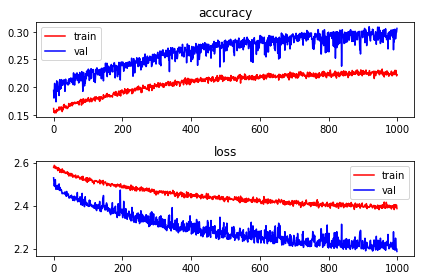

In [59]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [24]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.051

confusion matrix

[[  0   0   0   0   0   0   0   0 256   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 291   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 277   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 283   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 288   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 302   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 287   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 284   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 290   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 307   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 304   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 294   0   0 